<a href="https://colab.research.google.com/github/yungcm/github-slideshow/blob/master/Netket_tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install netket

     |████████████████████████████████| 204kB 10.5MB/s 
     |████████████████████████████████| 1.4MB 10.6MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
  Created wheel for netket: filename=netket-2.1.1-cp36-cp36m-linux_x86_64.whl size=1205685 sha256=fff9d39a3c5aef8f2fdcc7d9a8fe6034b4eaa2b67778485db4bd519781123107
  Stored in directory: /root/.cache/pip/wheels/d8/4a/31/b5fb6c96ec4f28f07fb48f3a1f01b991fffef216e2c68bf06d
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp36-cp36m-linux_x86_64.whl size=2074467 sha256=a9d90164aec28864adf974f158488272fe316ac5f6b2fd279ac9a81bd20f0661
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built netket mpi4py
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


## Learning the ground-state of a spin model with different Neural Networks available in NetKet

https://www.netket.org/tutorials/heisenberg.html

In [3]:
# Import netket library
import netket as nk
# Import Json, this will be needed to examine log files
import json
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# 0) Defining the Hamiltonian

In [4]:
# Define a 1d chain
L = 22
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

In [5]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero
hi = nk.hilbert.Spin(s=0.5, graph=g, total_sz=0)

In [6]:
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi)

# 1. Exact Diagonalization (as a testbed)

In [7]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
exact_result = nk.exact.lanczos_ed(ha, first_n=1, compute_eigenvectors=False)
exact_gs_energy = exact_result.eigenvalues[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

# Just in case you can't do this calculation, here is the result
# exact_gs_energy = -39.14752260706246

The exact ground-state energy is E0= -39.14752260706285


# 2. Starting simple: the Jastrow ansatz

In [8]:
ma = nk.machine.Jastrow(hilbert=hi)
ma.init_random_parameters(seed=1, sigma=0.01)

In [9]:
# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.1)

# Sampler
sa = nk.sampler.MetropolisExchange(machine=ma)
ma.init_random_parameters(seed=12, sigma=0.01)

# Stochastic reconfiguration
gs = nk.variational.Vmc(
    hamiltonian=ha,
    sampler=sa,
    optimizer=op,
    n_samples=1000,
    diag_shift=0.1,
    method='Sr')

start = time.time()
gs.run(out='Jastrow', n_iter=300)
end = time.time()

print('### Jastrow calculation')
print('Has',ma.n_par,'parameters')
print('The Jastrow calculation took',end-start,'seconds')

100%|██████████| 300/300 [00:40<00:00,  7.48it/s, Energy=(-39.112 - 0.000i) ± 0.016 [var=0.241, R=1.00029]]

### Jastrow calculation
Has 231 parameters
The Jastrow calculation took 40.108975648880005 seconds


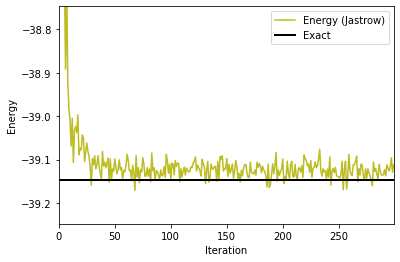

In [15]:
# import the data from log file
data=json.load(open("Jastrow.log"))

# Extract the relevant information
iters_Jastrow=[]
energy_Jastrow=[]

for iteration in data["Output"]:
    iters_Jastrow.append(iteration["Iteration"])
    energy_Jastrow.append(iteration["Energy"]["Mean"])

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.1,exact_gs_energy+0.4])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_Jastrow[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()


# 3. Learning with a Restricted Boltzmann Machine (RBM)

In [10]:
# RBM ansatz with alpha=1
ma = nk.machine.RbmSpin(alpha=1, hilbert=hi)

In [11]:
# Sampler
sa = nk.sampler.MetropolisExchange(machine=ma)
ma.init_random_parameters(seed=123, sigma=0.01)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)
# Stochastic reconfiguration
gs = nk.variational.Vmc(
    hamiltonian=ha,
    sampler=sa,
    optimizer=op,
    n_samples=1000,
    diag_shift=0.1,
    use_iterative=True,
    method='Sr')

start = time.time()
gs.run(out='RBM', n_iter=600)
end = time.time()

print('### RBM calculation')
print('Has',ma.n_par,'parameters')
print('The RBM calculation took',end-start,'seconds')

100%|██████████| 600/600 [08:14<00:00,  1.21it/s, Energy=(-39.069 + 0.020i) ± 0.026 [var=0.556, R=1.00151]]

### RBM calculation
Has 528 parameters
The RBM calculation took 494.20283699035645 seconds


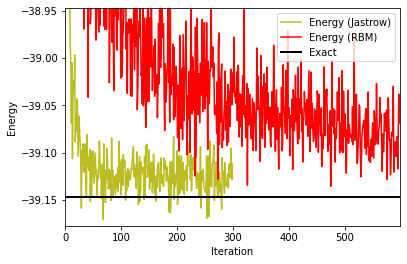

In [16]:
# import the data from log file
data=json.load(open("RBM.log"))

# Extract the relevant information
iters=[]
energy_RBM=[]

for iteration in data["Output"]:
    iters.append(iteration["Iteration"])
    energy_RBM.append(iteration["Energy"]["Mean"])

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.plot(iters, energy_RBM, color='red', label='Energy (RBM)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

# 4. RBM again, this time with lattice symmetries

In [12]:
# Symmetric RBM Spin Machine
ma = nk.machine.RbmSpinSymm(alpha=1, hilbert=hi)
ma.init_random_parameters(seed=1234, sigma=0.01)

# Metropolis Exchange Sampling
# Notice that this sampler exchanges two neighboring sites
# thus preservers the total magnetization
sa = nk.sampler.MetropolisExchange(machine=ma)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic reconfiguration
gs = nk.variational.Vmc(
    hamiltonian=ha,
    sampler=sa,
    optimizer=op,
    n_samples=1000,
    diag_shift=0.1,
    use_iterative=True,
    method='Sr')

start = time.time()
gs.run(out='RBMSymmetric', n_iter=300)
end = time.time()

print('### Symmetric RBM calculation')
print('Has',ma.n_par,'parameters')
print('The Symmetric RBM calculation took',end-start,'seconds')

100%|██████████| 300/300 [03:38<00:00,  1.37it/s, Energy=(-39.1526 + 0.0014i) ± 0.0067 [var=0.0425, R=1.00050]]

### Symmetric RBM calculation
Has 24 parameters
The Symmetric RBM calculation took 218.9165976047516 seconds


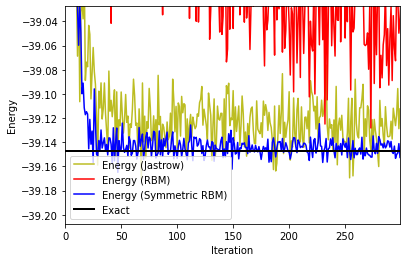

In [17]:
# import the data from log file
data=json.load(open("RBMSymmetric.log"))

# Extract the relevant information
energy_symRBM=[]
iters_symRBM=[]
for iteration in data["Output"]:
    energy_symRBM.append(iteration["Energy"]["Mean"])
    iters_symRBM.append(iteration["Iteration"])

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.plot(iters, energy_RBM, color='red', label='Energy (RBM)')
ax1.plot(iters_symRBM, energy_symRBM, color='blue', label='Energy (Symmetric RBM)')

ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_symRBM[-1],exact_gs_energy-0.06,exact_gs_energy+0.12])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

In [19]:
!ls

Jastrow.log  RBM.log	       RBMSymmetric.wf	sample_data
Jastrow.wf   RBMSymmetric.log  RBM.wf
